In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy.polynomial.polynomial as poly
import time
import hdbscan
import pandas as pd
from sklearn import linear_model
import pickle

In [2]:
#function to do color based segmentation
def combined (img):
    #b, g, r = cv2.split(img)
    b = img[:, :, 0]
    g = img[:, :, 1]
    r = img[:, :, 2]
    #r_max = g_max = b_max = 255
    r_max = np.amax(r)
    g_max = np.amax(g)
    b_max = np.amax(b)
    #print (r)
    #cv2.imshow("red chaneel",b)

    red_norm = r/r_max
    green_norm = g/g_max
    blue_norm = b/b_max

   # print(red_norm.shape)

    norm = red_norm + blue_norm + green_norm


    small_num = 0.0001
    r = red_norm/(norm+small_num)
    g = green_norm/(norm+small_num)
    b = blue_norm/(norm+small_num)

    #print('normalized r g b values: %d %d %d' %(r, g, b))

    ExG = 2*g - r - b #excess green

    #ExGR = ExG -1.4*r - g #excess green minus red

    #CIVE = 0.441*r - 0.811*g + 0.385*b + 18.78745 #color index of vegetation extraction

    #redistribute the weights without VEG
    #w_ExG = 0.28
    #w_ExGR = 0.34
    #w_CIVE = 0.38

    #combined = w_ExG * ExG + w_ExGR * ExGR + w_CIVE * CIVE

    return ExG

Height: 972 width: 1444


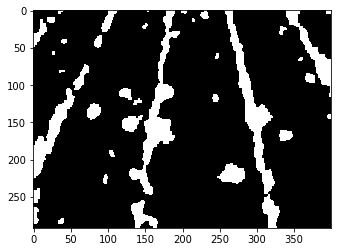

In [4]:

#Load original image, in real case it will video frame
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\Images\crop_row_061.jpg')

####   image from Veeras video  ######
img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\vid_img.PNG')

height = img.shape[0]
width = img.shape[1]

print("Height:",height,"width:",width)

#crop ROI
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3+40 ):int(120+(width / 3))] #r-wsmall
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3))] #small
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3+20))] #big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3-40):int(100+(width / 3))] #l-big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 40):int(140+(width / 3))] #vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(180+(width / 3))] #r-vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3 - 20))] #l-wsmall

### Crop image for Veera video ####
crop_img = img[int(height / 5):int(height / 2), int(width / 3):int(400+(width / 3))]


img = crop_img

max_value = np.max(combined(img))
min_value = np.min(combined(img))

###mapped combined image value (which is mostly negative) to 0-255
new_min = 0
new_max = 255
old_range = max_value - min_value
new_range = new_max - new_min
lin_map = (((combined(img).astype(np.float64) - min_value) * new_range) / old_range) + new_min
image_map = lin_map.astype(np.uint8)
###OTSU threshold
thresh_val,thresh_img = cv2.threshold(image_map,0,255,cv2.THRESH_OTSU)

#print(thresh_img)
###Morphology Opening-Closing to delete small weed segments
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#print(closing.shape)
plt.imshow(closing, cmap='gray')
### all the white pixel coordinates in segemented image after noise clean

indices = np.where(closing == [255])
coordinates = list(zip(indices[0], indices[1]))


In [14]:

###convert list to array
###then flip the data from x-y format to y-x format for clsuter fit
data = np.array(coordinates)
y_x_data = np.flip(data)

print(y_x_data.shape)

#### Test several cluster size ########
### using smaller cluster_size will keep smaller cluster ###
#cluster_size = 25
#cluster_size = 50 #small
#cluster_size = 100 #medium
#cluster_size = 200 #big

##### cluster size for Veera video image ####
cluster_size = 500 


###Fit data to HDBscan
### min_cluster_size=100, has direct correlation with crop growth stage, type of crop
### NEED user input
clusters = hdbscan.HDBSCAN(min_cluster_size=cluster_size).fit(y_x_data)
labels = clusters.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print("clusters:", n_clusters)
good_points = clusters.exemplars_

###subtract outliers from original cluster data
subtract_data = y_x_data

iteration = 0
#user defined integer
least_clusters_amount_in_ROI = 3
percent_of_data_to_keep = 0.85 
cluster_num_threshold = 2
iteration_break = 3



####  (n_clusters < least_clusters_amount_in_ROI) ::: to take care when weed connects crop rows and 3 rows become 2 rows

while (n_clusters < least_clusters_amount_in_ROI): #assuming there will be 3 or 4 clusters inside ROI

    clusters = hdbscan.HDBSCAN(min_cluster_size= cluster_size).fit(subtract_data)
    labels = clusters.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if (n_clusters > cluster_num_threshold) or (iteration > iteration_break):
        break
    
    ###Define outliers: points which are outside of 85% of clusters.outlier_scores_
    threshold = pd.Series(clusters.outlier_scores_).quantile(percent_of_data_to_keep)
    outliers = np.where(clusters.outlier_scores_ > threshold)[0]
    
    ###subtract outliers from original cluster data
    subtract_data = np.delete(subtract_data,outliers,axis=0)
    iteration = iteration+1
    print("iteration", iteration)
    
    labels = clusters.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    #print("clusters:", n_clusters)
 

### IMG 014 ###
### high weed pressure between the center two crop rows joins them and creates a very big cluster
### following logic check is a single cluster points are higher than a threshold.
### if YES, then it assumes multiple rows are connected via weed. Find cluster core points with "cluster.exemplars_".
### deleting points doesn't matter because weed is so dense, they are included in core points
### Re cluster the core points

### calculate data points in each cluster ###
Xdata_points = subtract_data.T[1]

data_points = [] #store number of (x,y) of a cluster on a list to see if there is big cluster
for i in range(0,n_clusters):
    data_points.append(Xdata_points[labels == i].shape[0])
print(data_points)


#all (x,y) point on a 2 column array in x,y format
good_data = np.empty((0,2))
for i in range(0,n_clusters):
    good_data = np.append(good_data,good_points[i],axis = 0)
#print("good data",good_data.shape)

##### For IMG015, if use the following logic instead of iterative method(use .exemplars_ to find good points when 
#### one big cluster present), it creates too many small clusters and wrong results for IMG015. So the iterative method
#### can't be replaced at this moment.

##  if (data_points[i] > cluster_data_threshold) or (n_clusters < least_clusters_amount_in_ROI): ##

#### For Veera video img ###
cluster_data_threshold = 5000   

#cluster_data_threshold = 1000  
if (data_points[i] > cluster_data_threshold):
    print("big cluster", i+1)
        
    good_clusters = hdbscan.HDBSCAN(min_cluster_size=10).fit(good_data) #Recluster the core points
    labels_good = good_clusters.labels_
    n_good_clusters = len(set(labels_good)) - (1 if -1 in labels_good else 0)
    #print("After Reclustering good points, new clusters in that:", n_good_clusters)
        
    Ydata_g = good_data.T[0] #we plot this on x-axis
    Xdata_g = good_data.T[1] #we plot this on y_axis
        
    for j in range(0,n_good_clusters):
        plt.scatter(np.array(Ydata_g[labels_good == j]), np.array(Xdata_g[labels_good == j])) 
    plt.gca().invert_yaxis()
    plt.title("Core points new cluster")
    
    subtract_data = good_data
    n_clusters = n_good_clusters
    labels = labels_good
        
        



(16407, 2)
clusters: 5
[3630, 1863, 5042, 540, 3976]


clusters: 5
(16407, 2)
cluster  1 center  36
cluster  2 center  373
cluster  3 center  294
cluster  4 center  180
cluster  5 center  157


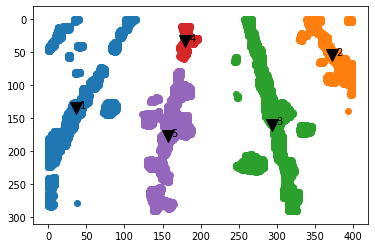

In [15]:

print("clusters:", n_clusters)
print(subtract_data.shape)

###convert list to array
subtract_data = np.array(subtract_data)

Ydata = subtract_data.T[0] #we plot this on x-axis
Xdata = subtract_data.T[1] #we plot this on y_axis

y_center = []
x_center = []

### calculate center for each clusters ###
for i in range(0,n_clusters):
    
    y_center.append(int(np.mean(np.array(Ydata[labels == i])))) #distance from (0,0) along x-axis
    x_center.append(int(np.mean(np.array(Xdata[labels == i])))) #distance from (0,0) along y-axis
    
    
    plt.scatter(np.array(Ydata[labels == i]), np.array(Xdata[labels == i])) 
    plt.plot(y_center[i],x_center[i], "kv",markersize=12)
    plt.text(y_center[i] + 5,x_center[i], s = i+1, fontsize =10)
    print("cluster ",i+1,"center ", y_center[i])

plt.gca().invert_yaxis()

In [82]:
# print("point in cluster 1", Xdata[labels == 0].shape[0])
# print("point in cluster 2", Xdata[labels == 1].shape[0])
# print("point in cluster 3", Xdata[labels == 2].shape[0])

In [16]:
### Check if clusters are at proper distance ###

### IMG 014: strict thresholding is needed ###
cluster_distance_threshold = 50  #this value can be updated based on user input or training data

center_distance = 0

### calculate dynamic threshold
center_sort = np.sort(y_center)

# for i in range(0,n_clusters):
#     j = i + 1
    
#     if (j < n_clusters):
#         center_distance += np.abs(center_sort[i] - center_sort[j]) 

#     #print(center_distance)

# ### dynamic calculation of cluster_distance_threshold ###
# cluster_distance_threshold = int(center_distance/(n_clusters + .001))
# print("threshold",cluster_distance_threshold)


percentage = 0.3 #bigger number means small distance constraint

###initialize with big numbers so that don't delete clusters (next cell) when don't meet following condition 
keep = 10
delete = 10

### currently the following loop works for only one outlier removal ####
### should apply it for multiple  outlier cluster removal ####

deleted_cluster = []

for i in range(0,n_clusters-1):
    for j in range(i+1,n_clusters):
        
        #print("i ",i,"j ", j)
        
        cluster_distance =  np.abs(y_center[i] - y_center[j])
        #print("cluster ",i+1,"and",j+1,"distance ",cluster_distance)
        
        if (cluster_distance < (cluster_distance_threshold - percentage * cluster_distance_threshold)):
            print ("Cluster trouble",i+1,"and",j+1)
            
            ### Decide which cluster to keep based on shape and size ###
            ### Keep : Higher number of points, higher vertical distance ###
            ### Higher number of points may also indicate weeds, maybe just keep higher vertical height ###
            
            #get number of data points in cluster
            cluster_i_points = Xdata[labels == i].shape[0]
            cluster_j_points = Xdata[labels == j].shape[0]
            
            #get height of cluster
            cluster_i_height = np.abs(max(Xdata[labels == i]) - min(Xdata[labels == i]))
            cluster_j_height = np.abs(max(Xdata[labels == j]) - min(Xdata[labels == j]))
            
            if ((cluster_i_height >= cluster_j_height) & (cluster_i_points >= cluster_j_points)):
                
                keep = i
                delete = j
            
            else:
                
                keep = j
                delete = i
                
            print("keep",keep+1)
            print("delete",delete+1)
            deleted_cluster.append(delete)
                


Cluster trouble 4 and 5
keep 5
delete 4


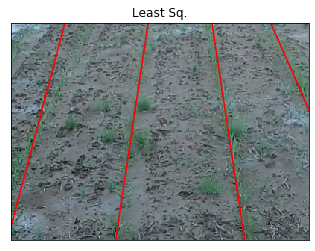

In [20]:
#### Fit line over clusters ####

straight = 1
curve = 2

#ls_time = []
#for ii in range(0,1000):
    
    #start_time = time.time()

#### For Veera video image ###
vertical_ROI_height = 290


#vertical_ROI_height = 80
total_points = 1000
for i in range(0,n_clusters):

    if (any(i == item for item in deleted_cluster)):
    #if (i == delete):
        pass

    else:

        coeff_cluster =  poly.polyfit(Xdata[labels == i], Ydata[labels == i], straight)
        xnew_cluster = np.linspace(0, vertical_ROI_height, 1000)
        ffit_cluster = poly.polyval(xnew_cluster, coeff_cluster)
        plt.plot(ffit_cluster, xnew_cluster, '-',color='red')
            
#     end_time = time.time()
#     diff = end_time-start_time
#     ls_time.append(diff)
    
# print("LS time: ",np.array(ls_time).mean())

                                    
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\GT_jpg\crop_row_061_GT.jpg')                              
 

#crop ROI
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3+40 ):int(120+(width / 3))] #r-wsmall
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3))] #small
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3+20))] #big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3-40):int(100+(width / 3))] #l-big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 40):int(140+(width / 3))] #vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(180+(width / 3))] #r-vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3 - 20))] #l-wsmall
                                    
#plt.gca().set_xlim([0,120])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"                                    
plt.gca().invert_yaxis()
plt.imshow(crop_img)
plt.title("Least Sq.")
#plt.title('Fitted lines on crop rows',fontweight='bold')
#plt.savefig(r"C:\Users\khan1\jupyter_test_code\IoU_value\challenge_scene\cluster_ls_challenge\cluster_ls_img061.png", bbox_inches='tight')
plt.show()
    

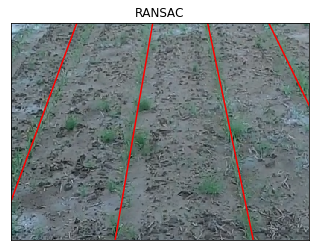

In [21]:
### Test Robust line fitting with RANSAC ###
straight = 1
curve = 2

ransac_time = []

# for ii in range(0,1000):
    
#     start_time = time.time()
    
ransac = linear_model.RANSACRegressor()

#### For Veera video image ###
vertical_ROI_height = 290
#vertical_ROI_height = 80
total_points = 1000
for i in range(0,n_clusters):

    if (any(i == item for item in deleted_cluster)):
    #if (i == delete):
        pass

    else:

        ransac.fit(Xdata[labels == i].reshape(-1,1), Ydata[labels == i].reshape(-1,1))
        xnew_cluster = np.linspace(0, vertical_ROI_height, 1000)
        ffit_cluster = ransac.predict(xnew_cluster.reshape(-1,1))
        plt.plot(ffit_cluster, xnew_cluster, '-',color='red')
            
#     end_time = time.time()
#     diff = end_time-start_time
#     ransac_time.append(diff)
    
# print("ransac time: ",np.array(ransac_time).mean())
# afile = open(r'C:\Users\khan1\jupyter_test_code\step3_ransac_time.pkl', 'wb')
# pickle.dump(ransac_time, afile)
# afile.close()

                                    
#img = cv2.imread(r'C:\Users\khan1\jupyter_test_code\CRBD\GT_jpg\crop_row_015_GT.jpg')                              


#crop ROI
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3+40 ):int(120+(width / 3))] #r-wsmall
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3))] #small
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(120+(width / 3+20))] #big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3-40):int(100+(width / 3))] #l-big
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 40):int(140+(width / 3))] #vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3):int(180+(width / 3))] #r-vbig
#crop_img = img[int(height / 5):int(80+(height / 5)), int(width / 3 - 20):int(120+(width / 3 - 20))] #l-wsmall
                                    
#plt.gca().set_xlim([0,120])
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"                                    
plt.gca().invert_yaxis()
plt.imshow(crop_img)
plt.title("RANSAC")
#plt.title('Fitted lines on crop rows',fontweight='bold')
#plt.savefig(r"C:\Users\khan1\jupyter_test_code\IoU_value\challenge_scene\cluster_ransac_challenge\cluster_ransac_img080.png", bbox_inches='tight')
plt.show()